<a href="https://colab.research.google.com/github/NathaBarbosa/Banco_de_Dados_TPF/blob/main/Trabalho_Pratico_2_Yago_Daniel_Natha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width: 100%; margin-left: auto; margin-right: auto; background-color: white;">
<tbody>
<tr>

<td style="text-align: center; width: 12%;"><img src=img/brasil-brasao.png alt="" /></td>

<td style="width: 68%;">
<h2 style="text-align: center; margin-top: 1%;">Rep&uacute;blica Federativa do Brasil</h2>
<h2 style="text-align: center; margin-top: 1%;">Minist&eacute;rio da Educa&ccedil;&atilde;o</h2>
<h2 style="text-align: center; margin-top: 1%;">Universidade Federal do Amazonas</h2>
<h2 style="text-align: center; margin-top: 1%;">Instituto de Computa&ccedil;&atilde;o</h2>
</td>

<td style="width: 12%;"><img src="img/UFAM-logo.png" alt="" /></td>

</tr>
</tbody>
</table>

---

# Ciência de Dados
## Trabalho Prático II: Modelagem de Dados

_Professor Dr. Marco Cristo_

**Alunos:**  `Yago Lobato, Daniel Trindade e Nathã Barbosa` <br>
**E-mail:** `yagobrlobato@icomp.ufam.edu.br, daniel.trindade@icomp.ufam.edu.br e NathaBarbosa@icomp.ufam.edu.br`

In [ ]:
# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import sklearn
import sys
import os
import warnings
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print("Python", sys.version)
print("--------")
print("Pandas:", pd.__version__)
print("Numpy:", np.__version__)
print("SKLearn:", sklearn.__version__)

Python 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
--------
Pandas: 2.2.2
Numpy: 2.0.2
SKLearn: 1.6.1


#### __Preliminares__: Inicialmente, vamos preparar os dados conforme estabelecido no primeiro trabalho prático. Para tanto, obtenha os dados das cidades dos membros da sua equipe no diretório `data`.

In [ ]:
DATA_PQT = '/content/drive/MyDrive/tp2/tp2/data/enem2019.parquet'
MUNICIPIOS = ['Goiânia', 'Belém', 'Belo Horizonte'] # Use o que foi especificado para os membros da sua equipe.

In [ ]:
# Caminho do arquivo
df_enem = pd.read_parquet(DATA_PQT)
df_enem.shape

(599982, 56)

In [ ]:
df_enem.columns

Index(['NO_MUNICIPIO_RESIDENCIA', 'SG_UF_RESIDENCIA', 'NU_IDADE', 'TP_SEXO',
       'TP_ESTADO_CIVIL', 'TP_NACIONALIDADE', 'NO_MUNICIPIO_NASCIMENTO',
       'SG_UF_NASCIMENTO', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA',
       'TP_ENSINO', 'IN_TREINEIRO', 'IN_SEM_RECURSO', 'NO_MUNICIPIO_PROVA',
       'SG_UF_PROVA', 'TP_PRESENCA_CN', 'TP_PRESENCA_CH', 'TP_PRESENCA_LC',
       'TP_PRESENCA_MT', 'CO_PROVA_CN', 'CO_PROVA_CH', 'CO_PROVA_LC',
       'CO_PROVA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT',
       'TP_LINGUA', 'TP_STATUS_REDACAO', 'NU_NOTA_REDACAO', 'Q001', 'Q002',
       'Q003', 'Q004', 'Q005', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011',
       'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020',
       'Q021', 'Q022', 'Q023', 'Q024', 'Q025'],
      dtype='object')

In [ ]:
# Remove todas as instâncias que não possuem valores para as colunas NO_MUNICIPIO_NASCIMENTO ou SG_UF_NASCIMENTO.
# Para as colunas CO_PROVA_CN, CO_PROVA_CH, CO_PROVA_LC, CO_PROVA_MT e TP_STATUS_REDACAO, remove apenas as instâncias
# onde todos esses valores encontram-se ausentes.
crit = ((df_enem.CO_PROVA_CN.isnull())&(df_enem.CO_PROVA_CH.isnull())&
        (df_enem.CO_PROVA_LC.isnull())&(df_enem.CO_PROVA_MT.isnull())&
        (df_enem.TP_STATUS_REDACAO.isnull()))
df_enem = df_enem[~crit]
display(df_enem.shape)

notas = [c for c in df_enem.columns if 'NU_NOTA' in c]
for c in notas:
    df_enem[c] = df_enem[c].fillna(0)

cods = [c for c in df_enem.columns if 'CO_PROVA' in c]
for c in cods:
    df_enem[c] = df_enem[c].fillna(500)

# Usando campo NU_IDADE, é criado FAIXA_ETARIA com os seguintes intervalos
# Instâncias com idade inferior a 10 ou superior a 100 anos sao removidas
def to_faixas(idade):
    if idade<18: return '10-18'
    elif idade<22: return '18-22'
    elif idade<26: return '22-26'
    elif idade<33: return '26-33'
    elif idade<40: return '33-40'
    elif idade<55: return '40-55'
    elif idade<63: return '55-65'
    elif idade<70: return '65-70'
    else: return '70-100'

df_enem = df_enem[(df_enem.NU_IDADE>=10)&(df_enem.NU_IDADE<=100)]
df_enem['FAIXA_ETARIA'] = df_enem.NU_IDADE.apply(to_faixas)

display(df_enem.FAIXA_ETARIA.value_counts())

nota_media = df_enem.NU_NOTA_REDACAO.mean()
df_enem['TARGET'] = df_enem.NU_NOTA_REDACAO.apply(lambda v: 1 if v>nota_media else 0)

cols_to_use = ['FAIXA_ETARIA', 'NO_MUNICIPIO_RESIDENCIA', 'TP_SEXO', 'TP_ESTADO_CIVIL',
               'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'CO_PROVA_CH',
               'CO_PROVA_LC', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'Q001',
               'Q002', 'Q003', 'Q004', 'Q005', 'Q006', 'Q021', 'Q022', 'Q024', 'Q025']

df_enem_c = df_enem[df_enem.NO_MUNICIPIO_PROVA.isin(MUNICIPIOS)][cols_to_use + ['TARGET']].copy()

(461570, 56)

,count
FAIXA_ETARIA,
18-22,193068
10-18,121679
22-26,59240
26-33,42011
33-40,22444
40-55,20065
55-65,2462
65-70,495
70-100,99


<div class="alert alert-info" >
<b>1 - MODELAGEM:</b> Usando o dataset <b>df_enem_c</b>, o seu objetivo é prever que alunos vão obter uma nota na redação acima da nota média observada nas cidades associadas com a sua equipe. Para tanto, prepare um pipeline de comparação justo entre os métodos, onde:
    
- Variáveis categóricas devem ser codificadas com One-hot;
- Variáveis numéricas devem ser padronizadas (z-score);
- Todos os métodos comparados devem ser otimizados (usando uma ténica de busca em _grid_ e validação cruzada) de acordo com o conjunto _mínimo_ de hiper-parâmetros descritos na tabela abaixo:

| Método | Número mínimo de parâmetros a serem avaliados |
|-----------|-------|
| __Naive Bayes__ |  |
| __Logistic Regression__ | - __C__: 0.1, 1, 10<br>- __penalty__: L2<br>- __solver__: lbfgs, liblinear |
| __Decision Tree__ | - __max_depth__: None, 8, 16<br>- __min_samples_leaf__: 1, 5, 18 |
| __Support Vector Machine__ | - __C__: 0.5, 1, 4<br>- __kernel__: linear, rbf<br>- __gamma__: scale |
| __Neural Network__ | - __hidden_layer_sizes__: (64,), (128,)<br>- __activation__: relu, tanh<br>- __alpha__: 1e-4, 1e-3<br>- __learning_rate_init__: 1e-3 |
| __Random Forest__ | - __n_estimators__: 200, 400<br>- __max_depth__: None, 12<br>- __min_samples_leaf__: 1, 5 |
| __Gradient Boosting__ | - __learning_rate__: 0.05, 0.1<br>- __max_depth__: None, 8, 16<br>- __l2_regularization__: 0.0, 1.0 |

<b>2 - AVALIAÇÃO COMPARATIVA:</b> Os resultados devem ser comparados usando as métricas __Acurácia__, __F1__ e __AUC__. Em particular, todos os métodos devem ser comparados entre si quanto à significância estatística das diferenças entre os AUCs obtidos. Para isso, use o teste não paramétrico de Wilcoxon. Ao fim, as seguintes tabelas devem ser preenchidas:

| Método | Acurácia | F1 | AUC |
|--------|----------|----|-----|
| Naive Bayes |  |  |  |
| Logistic Regression |  |  |  |
| Decision Tree |  |  |  |
| SVM |  |  |  |
| Neural Networks |  |  |  |
| Random Forest |  |  |  |
| Gradient Boosting |  |  |  |


| Método 1 | Método 2 | p-value (diferença de AUCs) |
|-----------|-------|-------|
| Naive Bayes | Logistic Regression |  |
| Naive Bayes | Decision Tree |  |
| Naive Bayes | SVM |  |
| Naive Bayes | Neural Networks |  |
| Naive Bayes | Random Forest |  |
| Naive Bayes | Gradient Boosting |  |
| Logistic Regression  | Decision Tree |  |
| Logistic Regression | SVM |  |
| Logistic Regression | Neural Networks |  |
| Logistic Regression  | Random Forest |  |
| Logistic Regression  | Gradient Boosting |  |
| Decision Tree | SVM |  |
| Decision Tree | Neural Networks |  |
| Decision Tree  | Random Forest |  |
| Decision Tree  | Gradient Boosting |  |
| SVM | Neural Networks |  |
| SVM  | Random Forest |  |
| SVM  | Gradient Boosting |  |
| Neural Networks  | Random Forest |  |
| Neural Networks  | Gradient Boosting |  |
| Random Forest  | Gradient Boosting |  |

<b>3 - EXPLICAÇÃO:</b> Finalmente, reporte a contribuição de cada variável usada pelo __melhor modelo__, usando o SHAP (use summary plots). Ao reportar o nome das variáveis, use nomes interpretáveis (ex: EducacaoDePaiOuResponsavel em lugar de Q001)

</div>

#EDA base

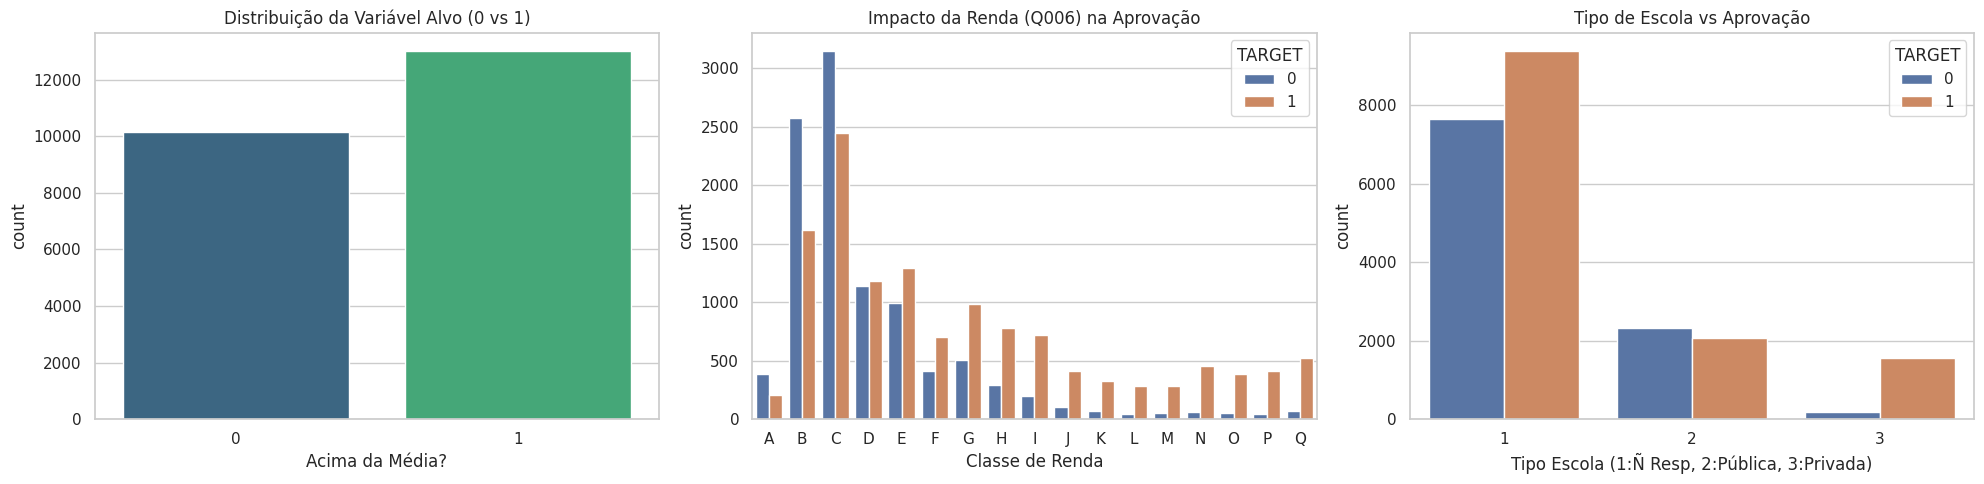

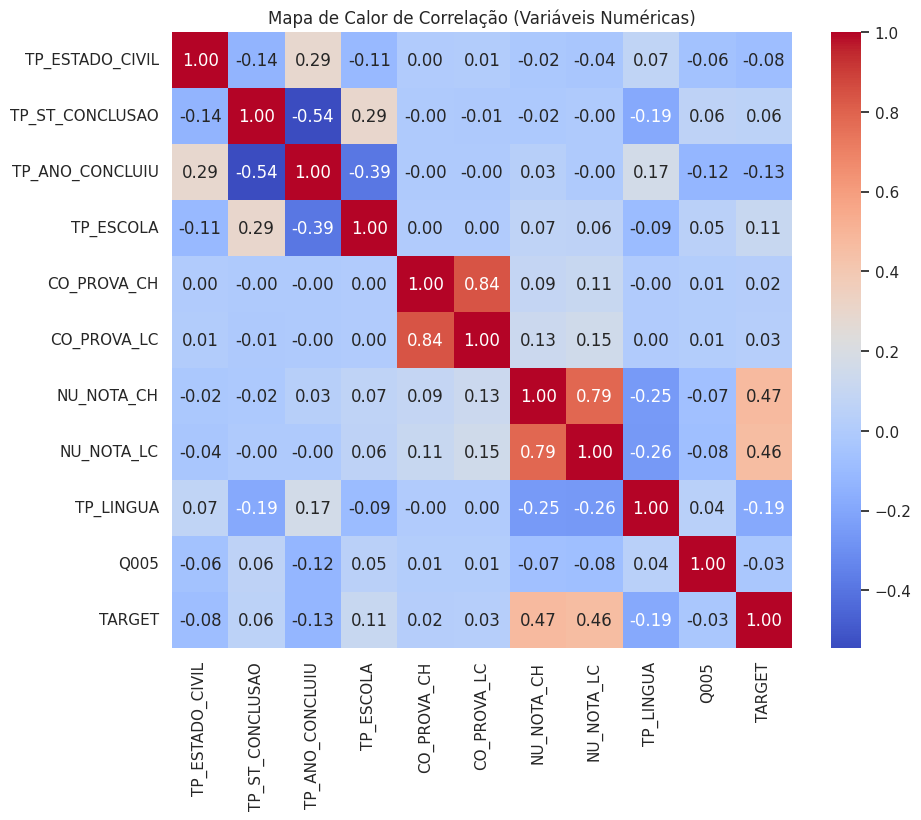

In [ ]:
# Configurações visuais
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# 1. Distribuição do Alvo (Balanceamento)
sns.countplot(data=df_enem_c, x='TARGET', ax=axes[0], palette='viridis')
axes[0].set_title("Distribuição da Variável Alvo (0 vs 1)")
axes[0].set_xlabel("Acima da Média?")

# 2. Renda (Q006) vs Target
# Q006 é uma proxy de renda. Vamos ver a proporção.
sns.countplot(data=df_enem_c, x='Q006', hue='TARGET', ax=axes[1], order=sorted(df_enem_c['Q006'].unique()))
axes[1].set_title("Impacto da Renda (Q006) na Aprovação")
axes[1].set_xlabel("Classe de Renda")

# 3. Tipo de Escola vs Target
sns.countplot(data=df_enem_c, x='TP_ESCOLA', hue='TARGET', ax=axes[2])
axes[2].set_title("Tipo de Escola vs Aprovação")
axes[2].set_xlabel("Tipo Escola (1:Ñ Resp, 2:Pública, 3:Privada)")

plt.tight_layout()
plt.show()

# Matriz de Correlação (apenas numéricas)
plt.figure(figsize=(10, 8))
numeric_preview = df_enem_c.select_dtypes(include=[np.number])
sns.heatmap(numeric_preview.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Mapa de Calor de Correlação (Variáveis Numéricas)")
plt.show()

#1

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier,  GradientBoostingClassifier


In [ ]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [ ]:
display(df_enem_c)

,FAIXA_ETARIA,NO_MUNICIPIO_RESIDENCIA,TP_SEXO,TP_ESTADO_CIVIL,TP_ST_CONCLUSAO,TP_ANO_CONCLUIU,TP_ESCOLA,CO_PROVA_CH,CO_PROVA_LC,NU_NOTA_CH,...,Q002,Q003,Q004,Q005,Q006,Q021,Q022,Q024,Q025,TARGET
259989,10-18,Belo Horizonte,F,1,3,0,1,509.0,514.0,534.8,...,D,C,B,4,H,A,E,B,B,1
259990,10-18,Ribeirão das Neves,F,1,2,0,2,507.0,511.0,487.9,...,B,B,B,4,B,A,D,A,B,0
259991,18-22,Contagem,F,1,1,1,1,508.0,512.0,513.0,...,F,B,D,3,D,A,D,B,B,1
259992,33-40,Belo Horizonte,M,1,1,13,1,508.0,512.0,406.9,...,C,F,F,2,B,A,C,A,B,0
259993,10-18,Belo Horizonte,F,1,2,0,2,508.0,512.0,575.0,...,E,D,B,4,I,A,E,B,B,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
549978,18-22,Aparecida de Goiânia,F,1,1,1,1,507.0,511.0,560.8,...,D,B,A,3,E,A,C,A,B,1
549979,18-22,Goiânia,F,1,1,1,1,510.0,513.0,0.0,...,E,C,D,5,C,B,C,B,B,0
549980,10-18,Goiânia,M,1,3,0,1,510.0,513.0,383.7,...,F,D,D,4,H,A,E,B,B,0
549981,10-18,Goiânia,M,1,3,0,1,510.0,513.0,402.5,...,C,F,B,5,B,A,C,A,B,0


In [ ]:
# Separando X e y
df = df_enem_c.copy()
y = df["TARGET"].astype(int)
X = df.drop(columns=["TARGET"])

# Identificando variáveis
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

print("Numéricas:", numeric_cols)
print("Categóricas:", categorical_cols)

# Encoder com agrupamento de categorias raras + segurança contra categorias novas
ohe = OneHotEncoder(
    handle_unknown="infrequent_if_exist",
    min_frequency=50,
    sparse_output=False
)

# Pré-processamento com scaler + OHE
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', ohe, categorical_cols)
    ]
)

# Opcional: converter para float32 (economia de RAM)
preprocessor = Pipeline([
    ('ct', preprocessor),
    ('to32', FunctionTransformer(lambda arr: arr.astype(np.float32)))
])

Numéricas: ['TP_ESTADO_CIVIL', 'TP_ST_CONCLUSAO', 'TP_ANO_CONCLUIU', 'TP_ESCOLA', 'CO_PROVA_CH', 'CO_PROVA_LC', 'NU_NOTA_CH', 'NU_NOTA_LC', 'TP_LINGUA', 'Q005']
Categóricas: ['FAIXA_ETARIA', 'NO_MUNICIPIO_RESIDENCIA', 'TP_SEXO', 'Q001', 'Q002', 'Q003', 'Q004', 'Q006', 'Q021', 'Q022', 'Q024', 'Q025']


In [ ]:

# Modelos e seus parâmetros mínimos (grid search)
models_and_grids = {
    'NaiveBayes': {
        'estimator': Pipeline([('pre', preprocessor), ('clf', GaussianNB())]),
        'grid': {}
    },
    'Logistic Regression': {
        'estimator': Pipeline([('pre', preprocessor), ('clf', LogisticRegression(max_iter=5000))]),
        'grid': {'clf__C':[0.1,1,10], 'clf__penalty':['l2'], 'clf__solver':['lbfgs','liblinear']}
    },
    'Decision Tree': {
        'estimator': Pipeline([('pre', preprocessor), ('clf', DecisionTreeClassifier())]),
        'grid': {'clf__max_depth':[None,8,16], 'clf__min_samples_leaf':[1,5,18]}
    },
    'Random Forest': {
        'estimator': Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier())]),
        'grid': {'clf__n_estimators':[200,400], 'clf__max_depth':[None,12], 'clf__min_samples_leaf':[1,5]}
    },
    'Gradient Boosting': {
        'estimator': Pipeline([('pre', preprocessor), ('clf', HistGradientBoostingClassifier())]),
        'grid': {'clf__learning_rate':[0.05,0.1], 'clf__max_depth':[None,8,16], 'clf__l2_regularization':[0.0,1.0]}
    },
    'Neural Network': {
        'estimator': Pipeline([('pre', preprocessor), ('clf', MLPClassifier(max_iter=1200))]),
        'grid': {'clf__hidden_layer_sizes':[(64,), (128,)], 'clf__activation':['relu','tanh'],
                 'clf__alpha':[1e-4,1e-3], 'clf__learning_rate_init':[1e-3]}
    },
      'SVM': {
        'estimator': Pipeline([('pre', preprocessor), ('clf', SVC(probability=True))]),
        'grid': {'clf__C':[0.5,1,4], 'clf__kernel':['linear','rbf']}
    }
}
print("\n Modelagem configurada com sucesso!")


 Modelagem configurada com sucesso!


#2

In [ ]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from scipy.stats import wilcoxon
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_predict
import itertools
from sklearn.experimental import enable_halving_search_cv  #
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.base import clone

In [ ]:
results = {}

main_metric = "accuracy"
scoring = {
    'accuracy': 'accuracy',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

print("\nTreinando modelos...\n")

for name, spec in models_and_grids.items():

    print(f"\n-----------------------------------\nAjustando modelo: {name}\n-----------------------------------\n")

    grid = spec.get('grid', {})

    if len(grid) == 0:
        print(f"- Grid vazio para {name}. Usando parâmetros padrão.")
        search = clone(spec['estimator'])
    else:
        search = HalvingGridSearchCV(
            estimator=spec['estimator'],
            param_grid=grid,
            scoring=main_metric,
            cv=inner_cv,
            factor=2,
            n_jobs=1,
            refit=True,
        )

    # ---- Cross-Validation (validação externa) ----
    print("\nIniciando validação cruzada...")
    cv_results = cross_validate(
        search,
        X,
        y,
        cv=outer_cv,
        scoring=scoring,
        return_estimator=False,
        n_jobs=1,
    )

    # coleta os estimadores (um por fold)
    results[name] = {
        'scores': cv_results,
          'mean': {k: np.mean(v) for k, v in cv_results.items() if k.startswith('test_')},
          'std':  {k: np.std(v, ddof=1) for k, v in cv_results.items() if k.startswith('test_')}
    }

    print("___" * 22, "\n")

print("\nAvaliação concluída!\n")



Treinando modelos...


-----------------------------------
Ajustando modelo: NaiveBayes
-----------------------------------

- Grid vazio para NaiveBayes. Usando parâmetros padrão.

Iniciando validação cruzada...
__________________________________________________________________ 


-----------------------------------
Ajustando modelo: Logistic Regression
-----------------------------------


Iniciando validação cruzada...
__________________________________________________________________ 


-----------------------------------
Ajustando modelo: Decision Tree
-----------------------------------


Iniciando validação cruzada...
__________________________________________________________________ 


-----------------------------------
Ajustando modelo: Random Forest
-----------------------------------


Iniciando validação cruzada...
__________________________________________________________________ 


-----------------------------------
Ajustando modelo: Gradient Boosting
-----------------

In [ ]:
summary_rows = []
for name, res in results.items():
    row = {'model': name}
    for k in results[name]['mean']:
        metric = k.replace('test_', '')
        row[f'{metric}_mean'] = results[name]['mean'][k]
        row[f'{metric}_std']  = results[name]['std'][k]
    summary_rows.append(row)

summary_df = pd.DataFrame(summary_rows).sort_values(by=f'{main_metric}_mean', ascending=False)
display(summary_df)

,model,accuracy_mean,accuracy_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
4,Gradient Boosting,0.760138,0.004744,0.783822,0.005227,0.838907,0.005031
6,SVM,0.759447,0.004872,0.787180,0.004084,0.836900,0.004833
1,Logistic Regression,0.758195,0.004095,0.788118,0.003460,0.836838,0.004696
3,Random Forest,0.756338,0.004820,0.781957,0.004445,0.834256,0.005305
2,Decision Tree,0.737206,0.006151,0.759891,0.007191,0.811160,0.005057
5,Neural Network,0.683092,0.003319,0.718240,0.003516,0.747340,0.006826
0,NaiveBayes,0.663356,0.004728,0.645459,0.005753,0.746129,0.003554


In [ ]:
model_names = list(results.keys())
a_lst, b_lst, p_values = [], [], []

for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        a, b = model_names[i], model_names[j]
        sa = results[a]['scores'][f'test_{main_metric}']
        sb = results[b]['scores'][f'test_{main_metric}']
        stat, p = wilcoxon(sa, sb, zero_method='wilcox', alternative='two-sided')
        a_lst.append(a); b_lst.append(b); p_values.append(p)

wilcox_df = pd.DataFrame({
    'model_A': a_lst,
    'model_B': b_lst,
    'p_value': p_values,
})

wilcox_df["Diferença Significativa?"] = wilcox_df["p_value"].apply(lambda x: "Sim" if x < 0.05 else "Não")
wilcox_df = wilcox_df.sort_values('p_value').reset_index(drop=True)

print(f"\n- Testes pareados em '{main_metric}' (Wilcoxon)")
display(wilcox_df)


- Testes pareados em 'accuracy' (Wilcoxon)


,model_A,model_B,p_value,Diferença Significativa?
0,NaiveBayes,Logistic Regression,0.0625,Não
1,NaiveBayes,Decision Tree,0.0625,Não
2,NaiveBayes,Random Forest,0.0625,Não
3,NaiveBayes,Gradient Boosting,0.0625,Não
4,NaiveBayes,Neural Network,0.0625,Não
5,NaiveBayes,SVM,0.0625,Não
6,Logistic Regression,Decision Tree,0.0625,Não
7,Logistic Regression,Neural Network,0.0625,Não
8,Decision Tree,SVM,0.0625,Não
9,Logistic Regression,SVM,0.0625,Não


#3

In [ ]:
import shap


In [ ]:
summary_df.columns
summary_df.head()

,model,accuracy_mean,accuracy_std,f1_mean,f1_std,roc_auc_mean,roc_auc_std
4,Gradient Boosting,0.760138,0.004744,0.783822,0.005227,0.838907,0.005031
6,SVM,0.759447,0.004872,0.787180,0.004084,0.836900,0.004833
1,Logistic Regression,0.758195,0.004095,0.788118,0.003460,0.836838,0.004696
3,Random Forest,0.756338,0.004820,0.781957,0.004445,0.834256,0.005305
2,Decision Tree,0.737206,0.006151,0.759891,0.007191,0.811160,0.005057


In [ ]:
# ---------------------------
# Vencedor + Re-treino final
# ---------------------------

winner_name = summary_df.iloc[0]['model']
print(f"\n>>> Vencedor pelo critério '{main_metric}': {winner_name}")

# Recuperando especificação
spec = models_and_grids[winner_name]
base_estimator = spec['estimator']
grid = spec.get('grid', {})

# Ajuste final com inner CV em TODO o dataset
if len(grid) == 0:
    print(f"\n- Grid vazio. Treinando {winner_name} com parâmetros padrão...")
    final_search = clone(base_estimator)
    final_search.fit(X, y)
    final_estimator = final_search
    best_params_final = {}

else:
    print("\nExecutando hiperparametrização final com HalvingGridSearchCV...")

    final_search = HalvingGridSearchCV(
        estimator=base_estimator,
        param_grid=grid,
        scoring=main_metric,
        cv=inner_cv,
        factor=2,
        n_jobs=1,          # importante para exibir logs
        refit=True,
        verbose=1
    )

    final_search.fit(X, y)
    final_estimator = final_search.best_estimator_
    best_params_final = final_search.best_params_

print("\nMelhores hiperparâmetros encontrados:")
print(best_params_final)

# ---------------------------
# Avaliação final com Cross-Val Predict
# ---------------------------

print("\nGerando previsões com validação cruzada externa...")
y_pred = cross_val_predict(final_estimator, X, y, cv=outer_cv, n_jobs=-1)



>>> Vencedor pelo critério 'accuracy': Gradient Boosting

Executando hiperparametrização final com HalvingGridSearchCV...
n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 2894
max_resources_: 23155
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 12
n_resources: 2894
Fitting 3 folds for each of 12 candidates, totalling 36 fits
----------
iter: 1
n_candidates: 6
n_resources: 5788
Fitting 3 folds for each of 6 candidates, totalling 18 fits
----------
iter: 2
n_candidates: 3
n_resources: 11576
Fitting 3 folds for each of 3 candidates, totalling 9 fits
----------
iter: 3
n_candidates: 2
n_resources: 23152
Fitting 3 folds for each of 2 candidates, totalling 6 fits

Melhores hiperparâmetros encontrados:
{'clf__l2_regularization': 0.0, 'clf__learning_rate': 0.05, 'clf__max_depth': None}

Gerando previsões com validação cruzada externa...


In [ ]:

def plot_confusion_matrix(y_true, predictions, class_names=None, normalize=True, threshold=0.5):
    """
    Plota matriz de confusão, aceitando tanto probabilidades quanto rótulos.

    Parâmetros:
    - y_true: vetor real
    - predictions: vetor de rótulos OU probabilidades (shape (n,) ou (n,2))
    - class_names: nomes das classes (lista opcional)
    - normalize: normalizar valores por linha
    - threshold: limite para converter probabilidades em classe (default 0.5)
    """

    # Se o modelo passou probabilidades (shape (n,2)), pegar somente da classe positiva
    if isinstance(predictions, np.ndarray) and predictions.ndim == 2:
        preds = (predictions[:, 1] >= threshold).astype(int)
    else:
        preds = predictions

    # Criar labels automaticamente se não fornecidos
    if class_names is None:
        unique_labels = sorted(list(set(y_true)))
        class_names = [f"Classe {c}" for c in unique_labels]

    # Calcula matriz de confusão
    cm = confusion_matrix(y_true, preds)

    # Normalizar
    if normalize:
        cm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

    # Plot
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt=".2f" if normalize else "d",
        cmap="Blues",
        cbar=True,
        xticklabels=class_names,
        yticklabels=class_names
    )

    plt.title("Matriz de Confusão")
    plt.ylabel("Rótulo Verdadeiro")
    plt.xlabel("Rótulo Predito")
    plt.tight_layout()
    plt.show()

    return cm


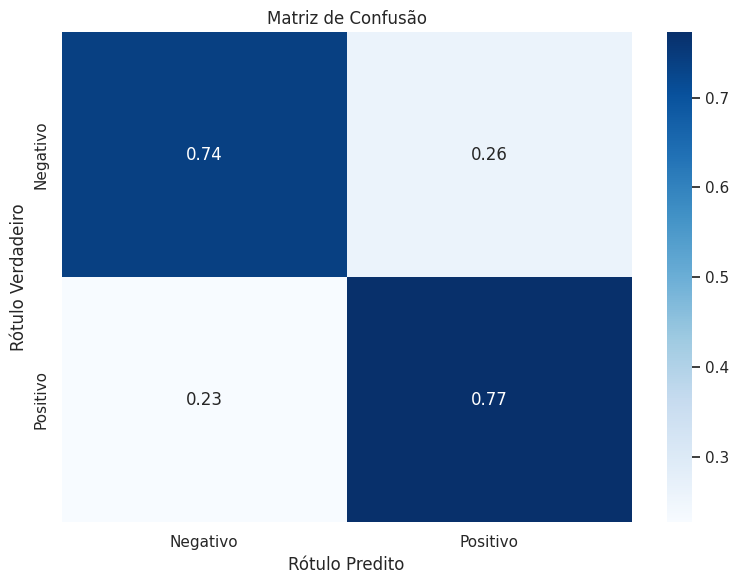

array([[0.74019704, 0.25980296],
       [0.22745098, 0.77254902]])

In [ ]:
plot_confusion_matrix(y, y_pred, class_names=["Negativo", "Positivo"])


In [ ]:
# salve casos de erro para explicação local
error_instance_indices = X[y_pred != y].index

In [ ]:
print(final_estimator.named_steps.keys())

dict_keys(['pre', 'clf'])


In [ ]:
prep = final_estimator.named_steps['pre']
X_tx = prep.transform(X)                  # já em float32
feature_names = list(numeric_cols)
cat_names = prep.named_steps['ct'].named_transformers_['cat'].get_feature_names_out(categorical_cols).tolist()
feature_names += cat_names

clf = final_estimator.named_steps['clf']

In [ ]:
rng = np.random.default_rng(RANDOM_STATE)
bg_n = min(200, X_tx.shape[0])           # background para o Explainer
sm_n = min(1000, X_tx.shape[0])          # pontos para cálculo dos shap_values

bg_idx = rng.choice(X_tx.shape[0], size=bg_n, replace=False)
sm_idx = rng.choice(X_tx.shape[0], size=sm_n, replace=False)

X_bg = X_tx[bg_idx]
X_sm = X_tx[sm_idx]

In [ ]:
# Escolha do Explainer
is_tree = isinstance(clf, (RandomForestClassifier, DecisionTreeClassifier))
if is_tree:
    explainer = shap.TreeExplainer(clf)
    shap_values = explainer.shap_values(X_sm)
else:
    explainer = shap.Explainer(clf, X_bg)
    shap_values = explainer(X_sm)

In [ ]:
shap_values.shape, len(feature_names)

((1000, 90), 90)


=== Importâncias SHAP — Top 20 features (amostra) ===
                                   feature  mean_abs_shap
0                               NU_NOTA_CH       0.763525
1                               NU_NOTA_LC       0.452178
2                                TP_SEXO_F       0.156576
3                          TP_ANO_CONCLUIU       0.143465
4                       FAIXA_ETARIA_18-22       0.115677
5                                TP_ESCOLA       0.111580
6                       FAIXA_ETARIA_10-18       0.102072
7   NO_MUNICIPIO_RESIDENCIA_Belo Horizonte       0.097017
8            NO_MUNICIPIO_RESIDENCIA_Belém       0.079550
9                                   Q006_B       0.056714
10                         TP_ST_CONCLUSAO       0.046887
11                               TP_SEXO_M       0.038725
12                                  Q001_G       0.037927
13                                  Q006_C       0.036426
14                      FAIXA_ETARIA_40-55       0.034768
15               

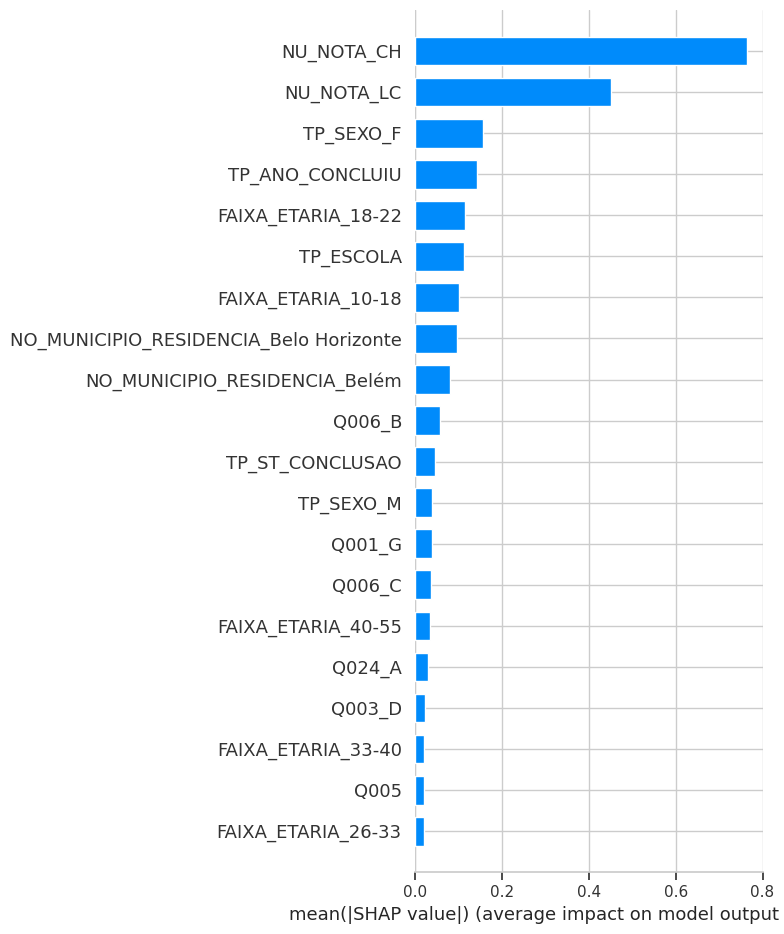

In [ ]:
import shap

# 1. Definição da função (cole isso no seu notebook)
def top20_importances(shap_values, feature_names):
    # ... (o corpo da função que você forneceu)
    if isinstance(shap_values, list):
        sv = shap_values[1]
    elif hasattr(shap_values, 'values'):
        sv = shap_values.values
    else:
        sv = shap_values

    # Garante array 3D (samples × features x classes)
    if sv.ndim == 3:
        sv = sv[:,:,1]  # Para formato multiclasse, usa classe 1

    # Calcula importância média absoluta por feature
    mean_abs_shap = np.mean(np.abs(sv), axis=0)

    # Cria ranking das top 20
    sorted_idx = np.argsort(mean_abs_shap)[::-1][:20]  # Ordem decrescente

    # Cria DataFrame
    result_df = pd.DataFrame({
        'feature': [feature_names[i] for i in sorted_idx],
        'mean_abs_shap': mean_abs_shap[sorted_idx]
    })

    return result_df

# 2. Chamada da função e impressão
top20 = top20_importances(shap_values, feature_names)
print("\n=== Importâncias SHAP — Top 20 features (amostra) ===")
print(top20)

# 3. Visualização (Gráfico de Barras SHAP)
# Este gráfico mostra as features ordenadas por importância global (a média absoluta)
shap.summary_plot(shap_values, X_sm, feature_names=feature_names, plot_type='bar')

In [ ]:
def create_local_plots(shap_values, X_data, feature_names, explainer, instance_indices=None, n_plots=3):
    """
    Cria waterfall plots para instâncias específicas
    """
    if instance_indices is None:
        # Seleciona as primeiras n_plots instâncias
        instance_indices = range(min(n_plots, X_data.shape[0]))

    # Obtém o valor base
    if hasattr(explainer, 'expected_value'):
        expected_value = explainer.expected_value
        if isinstance(expected_value, np.ndarray) and len(expected_value) == 2:
            base_value = expected_value[1]
        else:
            base_value = expected_value
    else:
        base_value = np.mean(clf.predict_proba(X_data)[:, 1])

    for idx in instance_indices:
        # Cria o objeto Explanation para esta instância
        explanation = shap.Explanation(
            values=shap_values[idx, :], # multiclass, pega classe = 1 (prob de ser femea)
            base_values=base_value,
            data=X_data[idx],
            feature_names=feature_names
        )

        # Plota
        plt.figure(figsize=(8, 6))
        shap.waterfall_plot(explanation, max_display=10, show=False)

        # Adiciona informações adicionais
        pred_proba = clf.predict_proba(X_data[idx:idx+1])[0, 1]
        plt.title(f"Waterfall Plot - Instância {idx}\nProbabilidade Classe 1: {pred_proba:.3f}")
        plt.tight_layout()
        plt.show()

        # Plota
        plt.figure(figsize=(8, 6))
        shap.force_plot(explanation, matplotlib=True)
        plt.show()


Índices de Instância para Plotagem (do conjunto X_sm): [np.int64(1), np.int64(989)]


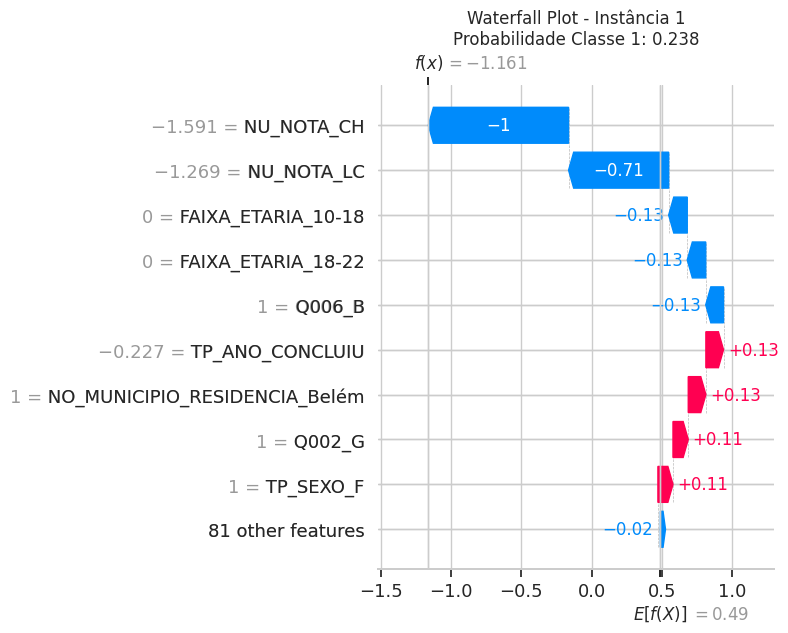

<Figure size 800x600 with 0 Axes>

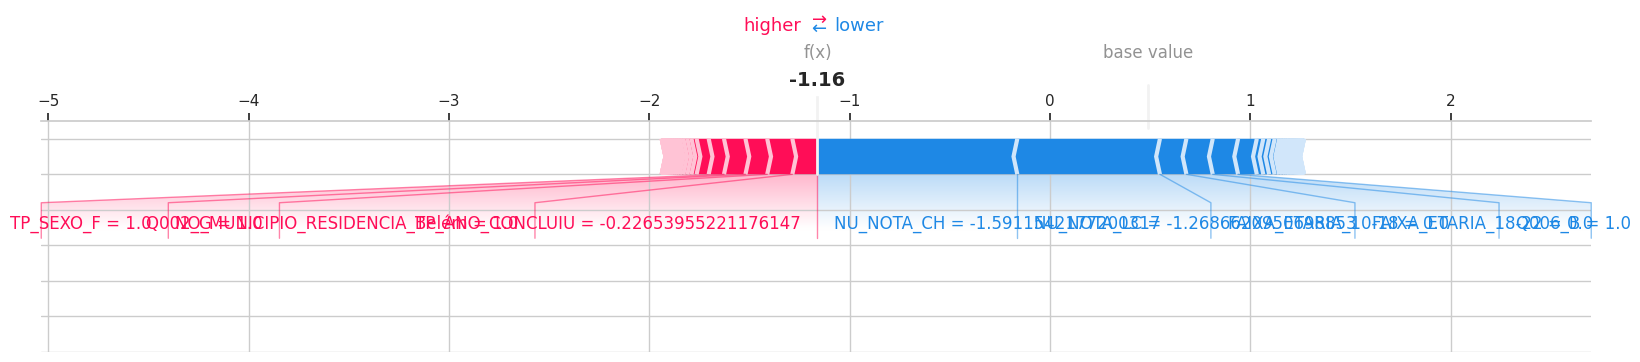

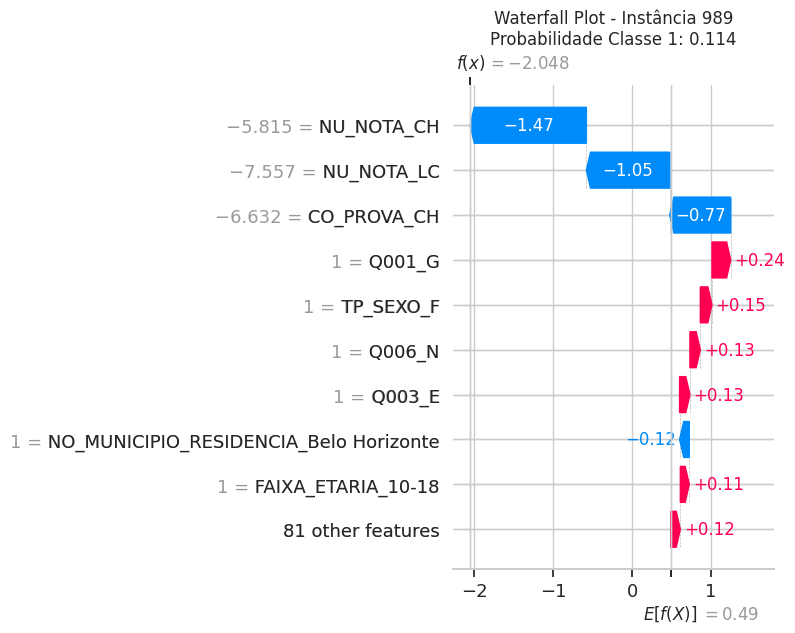

<Figure size 800x600 with 0 Axes>

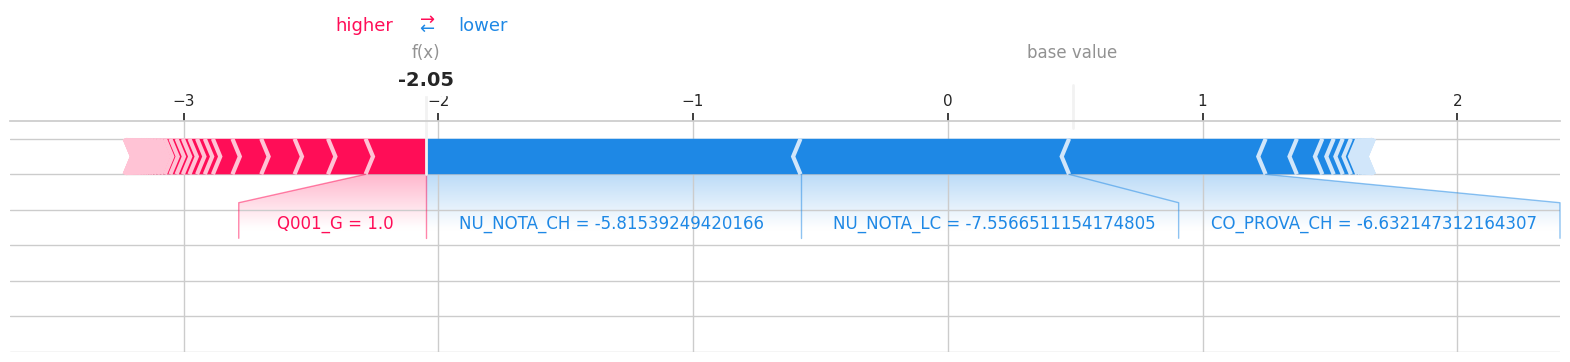

In [ ]:
if hasattr(shap_values, 'values'):
    sv_array = shap_values.values
else:
    sv_array = shap_values

# 1.2 Aplicar a lógica de indexação de classe para a PLOTAGEM
if sv_array.ndim == 3:
    if sv_array.shape[2] > 1:
        # Modelo Multiclasse (ou Binário com ambas as classes): Seleciona Classe 1
        shap_values_plot = sv_array[:, :, 1]
    else:
        # Modelo Binário (apenas 1 classe retornada): Seleciona a única Classe (índice 0)
        shap_values_plot = sv_array[:, :, 0]
elif sv_array.ndim == 2:
    # Modelo Binário (retorno 2D): Os valores já estão prontos
    shap_values_plot = sv_array
else:
    raise ValueError(f"Formato inesperado para sv_array: {sv_array.shape}. Esperado 2D ou 3D.")

# --- 2. Recalcular Magnitude e Índices ---
# Usamos a variável 'shap_values_plot' (que é a mesma 'sv_class' anterior)
shap_magnitude = np.sum(np.abs(shap_values_plot), axis=1)

idx_maior_magnitude = np.argsort(shap_magnitude)[-1]

# (Seu código para calcular idx_primeiro_erro aqui - assumindo que está correto)
try:
    # Use as variáveis que correspondem ao SEU conjunto X_sm
    indices_erros_sm = np.where(y_pred != y)[0]
    idx_primeiro_erro = indices_erros_sm[0]
except (NameError, IndexError):
    print("Aviso: Erro ao calcular índice de erro. Usando índice 0.")
    idx_primeiro_erro = 0 # Substituição de segurança

# Combinação dos índices para o plot
interesting_indices = [idx_primeiro_erro, idx_maior_magnitude]
print(f"\nÍndices de Instância para Plotagem (do conjunto X_sm): {interesting_indices}")


# --- 3. Plotagem Local Corrigida ---
# Passa o array de valores SHAP já indexado (shap_values_plot), que é 2D.
create_local_plots(shap_values_plot, X_sm, feature_names, explainer, instance_indices=interesting_indices)

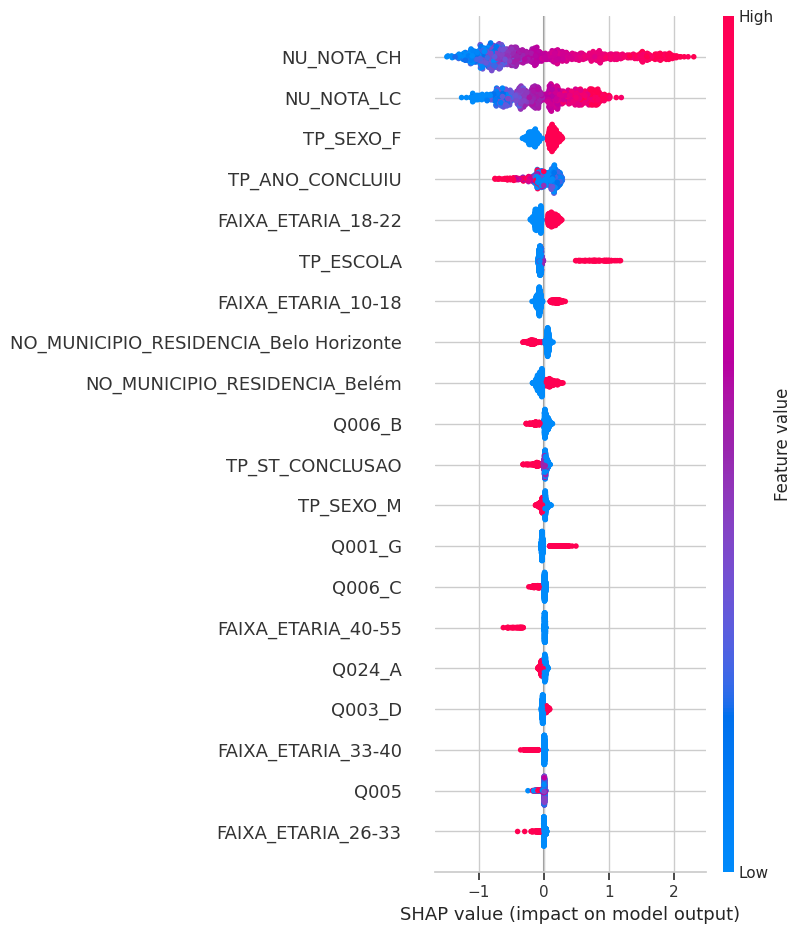

In [ ]:
shap.summary_plot(shap_values, X_sm, feature_names=feature_names)
